In [1]:
from keras.datasets import boston_housing

In [2]:
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

57344/57026 [==============================] - 0s 5us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [6]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [7]:
train_targets[0]

15.2

### Önce verileri normalize edeceğiz

İlgili sütundaki veriden ortalamasını çıkarıp standart sapmasına böleceğiz. Test veri setini normalize etmek için de train veri setinde bulduğumuz ortalama ve standart sapma değerini kullandık. Test veri seti üzerinden hesaplanmış değerleri ***kullanmayacağız.***

In [10]:
# Bu şekilde 0 değerine ortalanan bir dağılım elde ederiz.
mean=train_data.mean(axis=0)
std=train_data.std(axis=0)

train_data-=mean # Ortalama değeri çıkartıyoruz.
train_data/=std # Sonra standart sapmaya bölüyoruz.

test_data-=mean
test_data/=std

In [9]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

### Ağı inşa etmek.

Az sayıda verimiz olduğu için küçük bir ağ inşa edeceğiz.  64 birimli iki gizli katmanı olan bir ağ.

In [11]:
from keras import models
from keras import layers

In [12]:
# Aynı modeli birden fazla kere oluşturmak yerine bir fonksiyon haline getirebiliriz

def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
    return model

In [16]:
# K-Fold ile doğrulama
import numpy as np

k=4
num_val_samples=len(train_data)//k
num_epocs=100
all_scores=[]

for i in range(k):
    print("processing fold #",i)
    
    #k.ıncı parçadaki doğrulama verisi hazırlanır.
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    #Eğitim veri seti: Veriler diğer parçalardan gelir
    partial_train_data= np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets= np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model=build_model() # Modeli derler
    #Model sessiz modda (verbose=0) eğitilir.
    model.fit(partial_train_data,partial_train_targets,epochs=num_epocs,batch_size=1,verbose=0) 
    
    #Doğrulama verisi ile değerlendirilir.
    val_mse,val_mae=model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)
    
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
all_scores

[2.0196428298950195, 2.361495018005371, 2.7627718448638916, 2.4323480129241943]

In [18]:
# Ortalama Hata
np.mean(all_scores)

2.394064426422119

Ortalama olarak gereçek değere göre tahminlerimiz 2.394064426422119*10000= 2400 USD hatalı. Değeri daha iyileştirip iyileştirmeyeceğini görmek için epochs sayısını 500'e çıkartacağız. Bunu yaparken bu sefer her epochsta modelin ne kadar iyi olduğunu kaydedeceğiz. 

In [24]:
# K-Fold ile doğrulama
import numpy as np

k=4
num_val_samples=len(train_data)//k
num_epocs=500
all_mae_histories=[] 

for i in range(k):
    print("processing fold #",i)
    
    #k.ıncı parçadaki doğrulama verisi hazırlanır.
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    #Eğitim veri seti: Veriler diğer parçalardan gelir
    partial_train_data= np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets= np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model=build_model() # Modeli derler
    #Model sessiz modda (verbose=0) eğitilir.
    history=model.fit(partial_train_data,partial_train_targets,validation_data=(val_data,val_targets),
                      epochs=num_epocs,batch_size=1,verbose=0) 
    
    mae_history=history.history["val_mae"]
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [25]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epocs)]

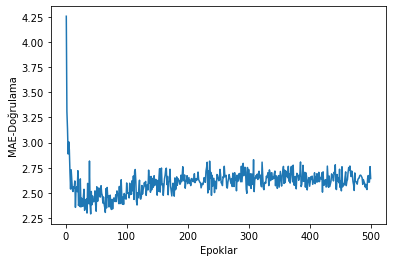

In [31]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel("Epoklar")
plt.ylabel("MAE-Doğrulama")
plt.show()

In [36]:
# Grafiğin okunurluğunu arttırmak için ilk 10 veri hariç moving average çizdirelim
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [37]:
smoothed_mae_history=smooth_curve(average_mae_history[10:])

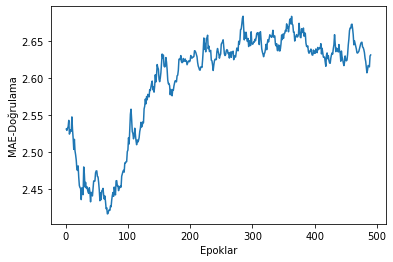

In [38]:
plt.plot(range(1,len(smoothed_mae_history)+1),smoothed_mae_history)
plt.xlabel("Epoklar")
plt.ylabel("MAE-Doğrulama")
plt.show()

In [34]:
smoothed_mae_history

[2.5314653515815735]

In [40]:
# K-Fold ile doğrulama
import numpy as np

k=4
num_val_samples=len(train_data)//k
num_epocs=80
all_scores=[]

for i in range(k):
    print("processing fold #",i)
    
    #k.ıncı parçadaki doğrulama verisi hazırlanır.
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    #Eğitim veri seti: Veriler diğer parçalardan gelir
    partial_train_data= np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets= np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model=build_model() # Modeli derler
    #Model sessiz modda (verbose=0) eğitilir.
    model.fit(partial_train_data,partial_train_targets,epochs=num_epocs,batch_size=1,verbose=0) 
    
    #Doğrulama verisi ile değerlendirilir.
    val_mse,val_mae=model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)
    
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [41]:
np.mean(all_scores)

2.6720386147499084